### Donwloading the map and making the graph

In [454]:
import timeit

import osmnx as ox
import networkx as nx

In [455]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import linprog
import math

In [457]:
G_man = ox.graph_from_place('Greater Manchester, England', network_type='drive')

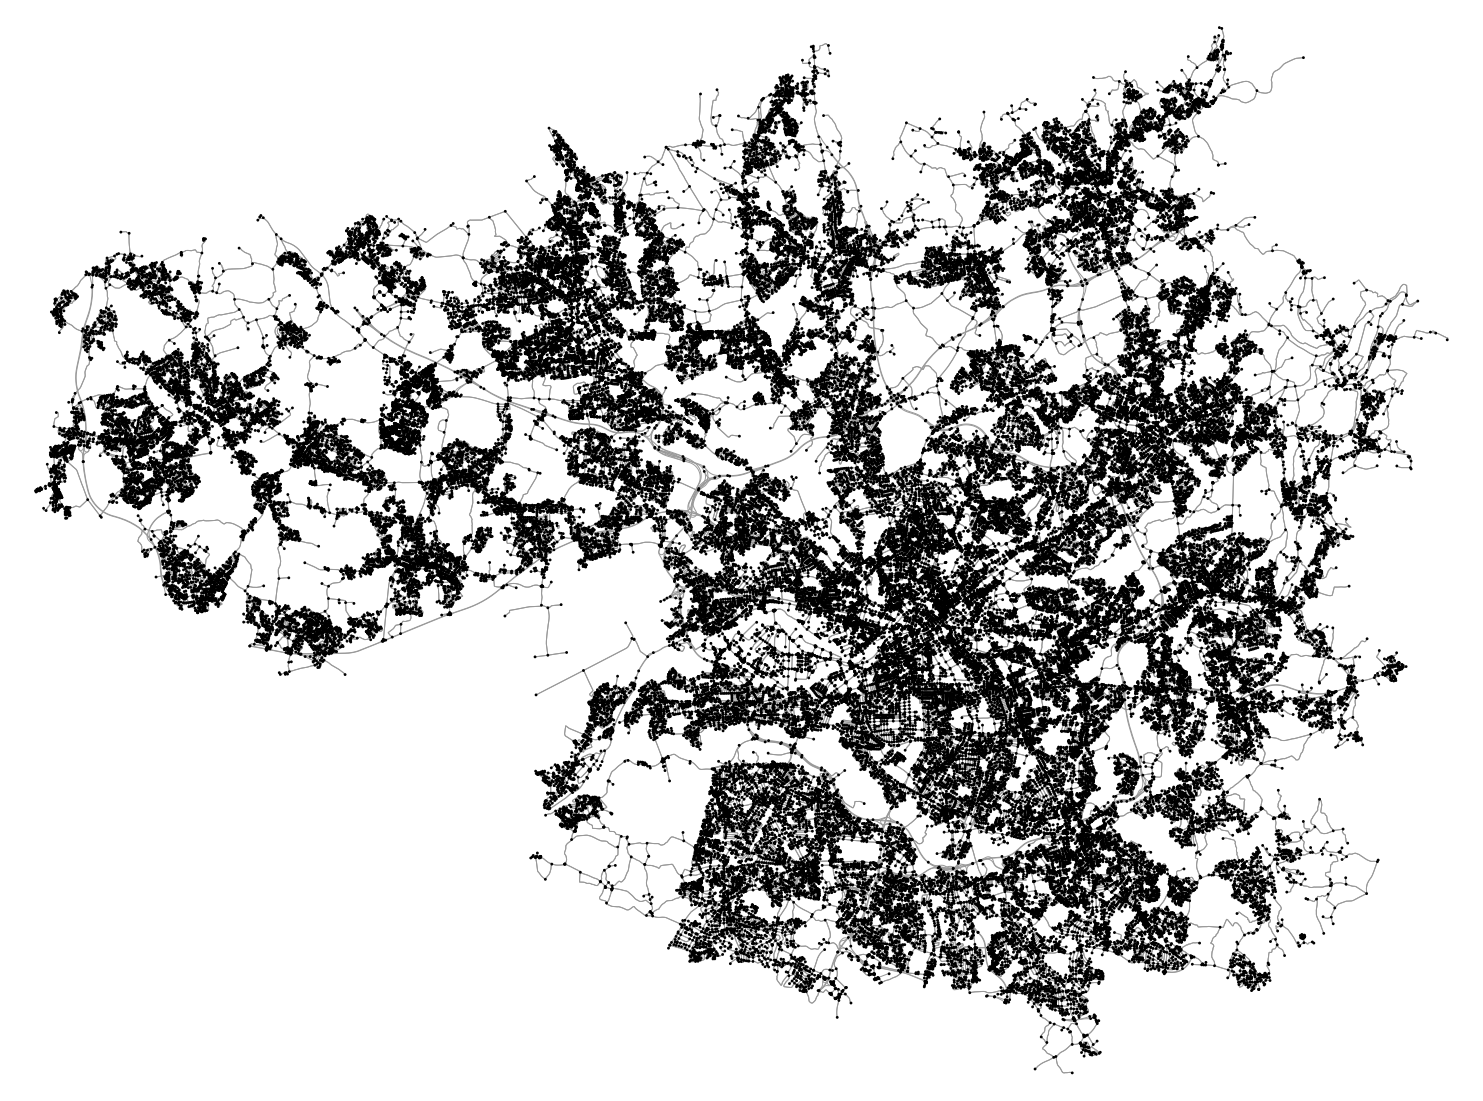

In [458]:
ox.plot_graph(G_man, bgcolor='#ffffff', figsize=(30, 20), node_color = 'black', node_size=8);

### Generating 10 delivery location and a storage location

In [459]:
list(G_man.nodes(data=True))

[(229542, {'y': 53.5043148, 'x': -2.6618782, 'osmid': 229542}),
 (229577,
  {'y': 53.5293432,
   'x': -2.6986583,
   'osmid': 229577,
   'ref': '26',
   'highway': 'motorway_junction'}),
 (229578, {'y': 53.5293509, 'x': -2.6984097, 'osmid': 229578}),
 (229635,
  {'y': 53.585424,
   'x': -2.6938596,
   'osmid': 229635,
   'ref': '27',
   'highway': 'motorway_junction'}),
 (229636, {'y': 53.5860598, 'x': -2.6935095, 'osmid': 229636}),
 (234914, {'y': 53.3729818, 'x': -2.3823132, 'osmid': 234914}),
 (234924,
  {'y': 53.359347,
   'x': -2.3014783,
   'osmid': 234924,
   'ref': '6',
   'highway': 'motorway_junction'}),
 (234929,
  {'y': 53.3717169,
   'x': -2.2909552,
   'osmid': 234929,
   'ref': '5',
   'highway': 'motorway_junction'}),
 (234931, {'y': 53.3764076, 'x': -2.2851227, 'osmid': 234931}),
 (234933, {'y': 53.3857918, 'x': -2.2757415, 'osmid': 234933}),
 (234940, {'y': 53.4021403, 'x': -2.2682892, 'osmid': 234940}),
 (234948, {'y': 53.410414, 'x': -2.266835, 'osmid': 234948}),
 (

In [460]:
list(G_man.edges(data=True))

[(229542,
  380222104,
  {'osmid': 3128706,
   'oneway': True,
   'lanes': '3',
   'ref': 'M6',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'length': 1695.213,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f8998854790>}),
 (229577,
  34104458,
  {'osmid': [5065148, 119020845, 119020847],
   'oneway': True,
   'lanes': ['1', '2'],
   'ref': 'M6',
   'highway': 'motorway_link',
   'maxspeed': '70 mph',
   'length': 652.1779999999999,
   'bridge': 'yes',
   'geometry': <shapely.geometry.linestring.LineString at 0x7f8998854ac0>}),
 (229577,
  34104607,
  {'osmid': [230600240, 119020841, 119020846],
   'oneway': True,
   'lanes': '3',
   'ref': 'M6',
   'highway': 'motorway',
   'maxspeed': '70 mph',
   'length': 575.3330000000001,
   'bridge': 'yes',
   'geometry': <shapely.geometry.linestring.LineString at 0x7f8998854940>}),
 (229578,
  229542,
  {'osmid': [3128706, 230600242, 119021046, 119021051, 119021052],
   'oneway': True,
   'lanes': '3',
   'ref': 'M6',
  

In [461]:
import random
delivery_spots = []
for i in range(10):
    loc = random.sample(list(G_man.nodes(data=True)), 1)
    while loc in delivery_spots:
        loc = random.sample(list(G_man.nodes(data=True)), 1)
    delivery_spots.append(loc[0])

In [462]:
delivery_spots

[(780158303, {'y': 53.6010651, 'x': -2.1498483, 'osmid': 780158303}),
 (33167909, {'y': 53.6367585, 'x': -2.3126632, 'osmid': 33167909}),
 (7384393033, {'y': 53.4988909, 'x': -2.5293404, 'osmid': 7384393033}),
 (5090287077, {'y': 53.6020911, 'x': -2.2870595, 'osmid': 5090287077}),
 (5241245205, {'y': 53.5560454, 'x': -2.4193572, 'osmid': 5241245205}),
 (1042587116, {'y': 53.4403753, 'x': -2.1562011, 'osmid': 1042587116}),
 (5239922303, {'y': 53.5619685, 'x': -2.3632688, 'osmid': 5239922303}),
 (1292291108, {'y': 53.4672315, 'x': -2.3200918, 'osmid': 1292291108}),
 (1398933020, {'y': 53.532707, 'x': -2.6647341, 'osmid': 1398933020}),
 (736152869, {'y': 53.4885043, 'x': -2.1002326, 'osmid': 736152869})]

In [463]:

minlat = 100000
maxlat = 0
minlon = 10000
maxlon = -10000
for el in list(G_man.nodes(data=True)):
    if el[1]['y'] < minlat:
        minlat = el[1]['y']
    if el[1]['y'] > maxlat:
        maxlat = el[1]['y']
    if el[1]['x'] < minlon:
        minlon=el[1]['x']
    if el[1]['x'] > maxlon:
        maxlon = el[1]['x']


In [464]:
minlat

53.3328957

In [465]:
maxlat


53.6688495

In [466]:
minlon


-2.7243336

In [467]:
maxlon

-1.9615224

In [468]:
y = (minlat + maxlat)/2
y

53.5008726

In [469]:
x = (minlon + maxlon)/2
x

-2.342928

In [470]:
storage_spot = [ox.get_nearest_node(G_man, (y, x))]

### Calculating the distances and time matrix based on length

In [471]:
delivery_spots

[(780158303, {'y': 53.6010651, 'x': -2.1498483, 'osmid': 780158303}),
 (33167909, {'y': 53.6367585, 'x': -2.3126632, 'osmid': 33167909}),
 (7384393033, {'y': 53.4988909, 'x': -2.5293404, 'osmid': 7384393033}),
 (5090287077, {'y': 53.6020911, 'x': -2.2870595, 'osmid': 5090287077}),
 (5241245205, {'y': 53.5560454, 'x': -2.4193572, 'osmid': 5241245205}),
 (1042587116, {'y': 53.4403753, 'x': -2.1562011, 'osmid': 1042587116}),
 (5239922303, {'y': 53.5619685, 'x': -2.3632688, 'osmid': 5239922303}),
 (1292291108, {'y': 53.4672315, 'x': -2.3200918, 'osmid': 1292291108}),
 (1398933020, {'y': 53.532707, 'x': -2.6647341, 'osmid': 1398933020}),
 (736152869, {'y': 53.4885043, 'x': -2.1002326, 'osmid': 736152869})]

In [472]:
array_locations = storage_spot + [el[0] for el in delivery_spots]

In [473]:
array_locations

[7087576584,
 780158303,
 33167909,
 7384393033,
 5090287077,
 5241245205,
 1042587116,
 5239922303,
 1292291108,
 1398933020,
 736152869]

In [474]:
matrix_path = [[] for i in range(len(array_locations))]
matrix_time = [[] for i in range(len(array_locations))]
matrix_dist = [[] for i in range(len(array_locations))]

In [475]:
matrix

[[0,
  [1290238431,
   1290238429,
   928057917,
   409129554,
   409129551,
   409129545,
   928057911,
   928057972,
   928056517,
   409129529,
   928052656,
   928056503,
   928056502,
   928056501,
   927087534,
   927087532,
   927087530,
   691561648,
   985254373,
   1615718156,
   691561642,
   691561683,
   693271550,
   691561596,
   691561598,
   691561600,
   985295628,
   691561608,
   691561618,
   510397245,
   691561607,
   691561621,
   691528433,
   691528428,
   510397428,
   510397422,
   339394,
   510397418,
   691528415,
   510397407,
   510397405,
   691528413,
   691528406,
   510397350,
   5622522566,
   510397375,
   243745093,
   5010169442,
   5010169445,
   243745102,
   243745104,
   510397060,
   1290036994,
   510397005,
   510396978,
   510396970,
   4005743400,
   243745139,
   243745165,
   4005743406,
   4005743417,
   339152,
   339155,
   339146,
   339158,
   3975127424,
   1041415314,
   927116790,
   1042588082,
   1042587976,
   1042587171,
 

In [476]:
for ind_1 in range(len(array_locations)):
    for ind_2 in range(len(array_locations)):
        if array_locations[ind_1] == array_locations[ind_2]:
            matrix_path[ind_1].append(0)
            matrix_time[ind_1].append(0)
            matrix_dist[ind_1].append(0)
        else:
            path = nx.shortest_path(G_man, array_locations[ind_1], array_locations[ind_2], weight='length', method='dijkstra')
#             ox.plot_graph_route(G_man, path, node_size=0);
            edge_attr = ox.utils_graph.get_route_edge_attributes(G_man, path)
            matrix_path[ind_1].append(path)
            sum_time = []
            sum_dist = []
            
            ## here i calculate time for the road based on maxspeed and length of the road
            ### magic numbers are to convert different metrics
            for el in edge_attr:
                try:
                    if type(el['maxspeed']) is list:
                        avg = sum([int(i.split()[0])* 1.60934 for i in el['maxspeed']])/len(el['maxspeed'])
                        time = (el['length']*0.001) / avg
                    else:
                        time = ((el['length']*0.001) / (int(el['maxspeed'].split()[0]) * 1.60934))
                    sum_time.append(time)
#                 time = sum([(el['length'] / int(el['maxspeed'].split()[0])) for el in edge_attr])
                except KeyError:
                    aver = 20* 1.60934
                    time = (el['length']*0.001) / aver
                    sum_time.append(time)
                sum_dist.append(el['length']*0.001)
            sum_time = sum(sum_time)
            sum_dist = sum(sum_dist)
            matrix_time[ind_1].append(sum_time)
            matrix_dist[ind_1].append(sum_dist)

In [477]:
matrix_dist

[[0,
  20.426451999999998,
  20.941671,
  14.974999999999996,
  15.078005999999997,
  10.260318000000003,
  16.973632000000013,
  12.051306999999996,
  7.357138000000002,
  25.187646000000008,
  19.043091999999998],
 [20.74991000000001,
  0,
  18.661478999999986,
  32.82839000000002,
  11.157169000000001,
  22.371802999999993,
  21.621374999999993,
  17.498307999999994,
  23.070832999999997,
  39.230481,
  14.113433999999996],
 [21.105497000000007,
  18.387219999999985,
  0,
  26.004404999999995,
  8.012128000000002,
  15.75926300000001,
  29.85036599999999,
  12.456644,
  26.110002999999995,
  31.819957999999996,
  28.707333999999992],
 [15.00309,
  32.07454099999999,
  25.948316000000005,
  0,
  23.668061000000016,
  12.749569,
  30.402836999999984,
  16.69410300000001,
  18.658207,
  12.704650999999997,
  32.51558399999998],
 [15.161847999999996,
  10.954089000000002,
  8.017526000000004,
  23.707394000000008,
  0,
  12.684763000000002,
  23.716092999999994,
  8.438833000000002,
  2

In [478]:
matrix_time

[[0,
  0.24829375721606073,
  0.40737815783104225,
  0.313862579276805,
  0.29199459035854414,
  0.2495812465565595,
  0.39649388879913516,
  0.2583106066254904,
  0.1565298122803373,
  0.5081202439095122,
  0.40834163694433745],
 [0.2530603480160753,
  0,
  0.39597063081760187,
  0.4336883884767119,
  0.23127470992249405,
  0.4837154817088579,
  0.5236548730121251,
  0.3978190676509209,
  0.4843640591795393,
  0.7879312551670111,
  0.29585460499335103],
 [0.41278734642476916,
  0.334045439804664,
  0,
  0.5303428780624059,
  0.1838891823149034,
  0.4263585797076234,
  0.6538128096877335,
  0.31423025277442934,
  0.5477624234601935,
  0.6456420648926187,
  0.640243223782361],
 [0.3125280611927872,
  0.42334196508832067,
  0.6169487129299385,
  0,
  0.47778764453573735,
  0.28296100161142673,
  0.6183586610778631,
  0.3444712998289155,
  0.3776764760709361,
  0.2650049916943176,
  0.6500570627296495],
 [0.30523911103457385,
  0.22822307591932095,
  0.18210072659185336,
  0.4827826010603

## Salesman Problem with LP

### minimizing time

In [479]:
def obj(x):
    
    sum_lst = []
#     for i in range(len(x)):
#         if i != j:
#             val = matrix_time_flat[i] * x[i]
#             sum_lst.append(val)
#     cost = sum(sum_lst)
    for i in range(len(matrix_time)):
        for j in range(len(matrix_time)):
            if i != j:
                val = matrix_time[i][j] * x[i, j]
                sum_lst.append(val)
    cost = sum(sum_lst)
    return cost
                    
                

In [480]:
x0 = [[0] * 11 for _ in range(len(matrix_time))]

In [481]:
for i in range(len(matrix_time)):
    for j in range(len(matrix_time)):
        print(i, j)
        if j - i == 1:
            x0[i][j] = 1
        else:
            x0[i][j] = 0
x0[len(matrix_time) - 1][0] = 1
            

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10


In [482]:
x0

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [483]:
import pulp

In [484]:
model = pulp.LpProblem('Optimization', pulp.LpMinimize)

In [485]:
len(matrix_time)

11

In [486]:
x = {}

In [487]:
for i in range(len(matrix_time)):
        for j in range(len(matrix_time)):
            lowerBound = 0
            upperBound = 1

            if i == j:
                upperBound = lowerBound
            x[i, j] = pulp.LpVariable('x' + '_' + str(i) +  str(j), lowerBound, upperBound, pulp.LpBinary)

In [488]:
x

{(0, 0): x_00,
 (0, 1): x_01,
 (0, 2): x_02,
 (0, 3): x_03,
 (0, 4): x_04,
 (0, 5): x_05,
 (0, 6): x_06,
 (0, 7): x_07,
 (0, 8): x_08,
 (0, 9): x_09,
 (0, 10): x_010,
 (1, 0): x_10,
 (1, 1): x_11,
 (1, 2): x_12,
 (1, 3): x_13,
 (1, 4): x_14,
 (1, 5): x_15,
 (1, 6): x_16,
 (1, 7): x_17,
 (1, 8): x_18,
 (1, 9): x_19,
 (1, 10): x_110,
 (2, 0): x_20,
 (2, 1): x_21,
 (2, 2): x_22,
 (2, 3): x_23,
 (2, 4): x_24,
 (2, 5): x_25,
 (2, 6): x_26,
 (2, 7): x_27,
 (2, 8): x_28,
 (2, 9): x_29,
 (2, 10): x_210,
 (3, 0): x_30,
 (3, 1): x_31,
 (3, 2): x_32,
 (3, 3): x_33,
 (3, 4): x_34,
 (3, 5): x_35,
 (3, 6): x_36,
 (3, 7): x_37,
 (3, 8): x_38,
 (3, 9): x_39,
 (3, 10): x_310,
 (4, 0): x_40,
 (4, 1): x_41,
 (4, 2): x_42,
 (4, 3): x_43,
 (4, 4): x_44,
 (4, 5): x_45,
 (4, 6): x_46,
 (4, 7): x_47,
 (4, 8): x_48,
 (4, 9): x_49,
 (4, 10): x_410,
 (5, 0): x_50,
 (5, 1): x_51,
 (5, 2): x_52,
 (5, 3): x_53,
 (5, 4): x_54,
 (5, 5): x_55,
 (5, 6): x_56,
 (5, 7): x_57,
 (5, 8): x_58,
 (5, 9): x_59,
 (5, 10): x_510

In [489]:
model += pulp.lpSum(obj(x))

In [490]:
# for i in range(len(matrix_time)):
#         model += pulp.lpSum([x[i,j] for j in range(1,len(matrix_time))]) == 2


In [491]:
#constraints
for k in range(len(matrix_time)):
    model+= pulp.lpSum([ x[(i,k)] for i in range(len(matrix_time)) if (i,k) in x]) == 1
    model+= pulp.lpSum([ x[(k,i)] for i in range(len(matrix_time)) if (k,i) in x]) == 1

In [492]:
lst = []
for i in range(len(matrix_time)):
    lst.append(pulp.LpVariable('u_' + str(i), cat='Integer'))
for i in range(len(matrix_time)):
    for j in range(len(matrix_time)):
        if i != j and (i!= 0 and j!= 0) and (i, j) in x.keys():
            model += pulp.lpSum([ lst[i] - lst[j] + n*x[i,j]]) <= len(matrix_time)-1

In [493]:
u

[u_0, u_1, u_2, u_3, u_4, u_5, u_6, u_7, u_8, u_9, u_10]

In [494]:
status = model.solve()
print(pulp.LpStatus[status])

Optimal


In [495]:
for i in range(len(matrix_time)):
    for j in range(len(matrix_time)):
        if pulp.value(x[i,j]) > 0:
            print(str(i) + '_' + str(j) + ': ' + str( pulp.value(x[i,j]) ))

0_0: 1.0
1_1: 1.0
2_2: 1.0
3_3: 1.0
4_4: 1.0
5_5: 1.0
6_6: 1.0
7_7: 1.0
8_8: 1.0
9_9: 1.0
10_10: 1.0


### minimizing distance

In [496]:
def obj(x):
    
    sum_lst = []
    for i in range(len(matrix_dist)):
        for j in range(len(matrix_dist)):
            if i != j:
                val = matrix_dist[i][j] * x[i, j]
                sum_lst.append(val)
    cost = sum(sum_lst)
    return cost

In [497]:
model_dist = pulp.LpProblem('Optimization', pulp.LpMinimize)

In [498]:
x = {}

In [499]:
for i in range(len(matrix_dist)):
        for j in range(len(matrix_dist)):
            lowerBound = 0
            upperBound = 1
            if i == j:
                upperBound = lowerBound

            x[i, j] = pulp.LpVariable('x' + '_' + str(i) +  str(j), lowerBound, upperBound, pulp.LpBinary)

In [500]:
model_dist += pulp.lpSum(obj(x))

In [501]:
#constraints
for k in range(len(matrix_dist)):lst = []
for i in range(len(matrix_time)):
    lst.append(pulp.LpVariable('u_' + str(i), cat='Integer'))
for i in range(len(matrix_time)):
    for j in range(len(matrix_time)):
        if i != j and (i!= 0 and j!= 0) and (i, j) in x.keys():
            model += pulp.lpSum([ lst[i] - lst[j] + n*x[i,j]]) <= len(matrix_time)-1
    model_dist+= pulp.lpSum([ x[(i,k)] for i in range(len(matrix_dist)) if (i,k) in x]) == 1
    model_dist+= pulp.lpSum([ x[(k,i)] for i in range(len(matrix_dist)) if (k,i) in x]) == 1

In [502]:
lst = []
for i in range(len(matrix_dist)):
    lst.append(pulp.LpVariable('u_' + str(i), cat='Integer'))
for i in range(len(matrix_dist)):
    for j in range(len(matrix_dist)):
        if i != j and (i!= 0 and j!= 0) and (i, j) in x.keys():
            model += pulp.lpSum([ lst[i] - lst[j] + n*x[i,j]]) <= len(matrix_dist)-1

In [503]:
status = model_dist.solve()
print(pulp.LpStatus[status])

Optimal
